In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('Fraud.csv')                                                             
df.head()   

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [5]:
df.shape

(6362620, 11)

# Data Cleaning

## 1. Missing values
There are several strategies for handling missing values, including removing rows or columns with missing values, filling missing values with a specific value, or using more advanced techniques like interpolation or modeling.

In [6]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with any missing values
df = df.dropna()

# Verify if there are any missing values left
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## 2. Handling Outliers
Outliers can be identified and treated in various ways. One common method is to use the Interquartile Range (IQR)

In [7]:
# Function to detect and cap outliers using IQR
def cap_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

# List of numerical features
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Cap outliers in numerical features
for feature in features:
    cap_outliers(df, feature)

# Verify by checking the descriptive statistics
print(df[features].describe())


             amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06   
mean   1.322667e+05   7.221247e+04    8.872275e+04    6.003940e+05   
std    1.462368e+05   1.024141e+05    1.393412e+05    8.369711e+05   
min    0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00   
25%    1.338957e+04   0.000000e+00    0.000000e+00    0.000000e+00   
50%    7.487194e+04   1.420800e+04    0.000000e+00    1.327057e+05   
75%    2.087215e+05   1.073152e+05    1.442584e+05    9.430367e+05   
max    5.017193e+05   2.682879e+05    3.606460e+05    2.357592e+06   

       newbalanceDest  
count    6.362620e+06  
mean     7.150404e+05  
std      9.673665e+05  
min      0.000000e+00  
25%      0.000000e+00  
50%      2.146614e+05  
75%      1.111909e+06  
max      2.779773e+06  


## 3. Multi-collinearity
To handle multi-collinearity, we calculate the Variance Inflation Factor (VIF):

In [8]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Feature Engineering
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Encode categorical variable
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Drop non-numeric columns and the target variable
X = df.drop(columns=['nameOrig', 'nameDest', 'isFraud'])

# Ensure all columns are numeric

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(float), i) for i in range(len(X.columns))]

print(vif_data)

          feature           VIF
0            step  2.736941e+00
1            type  2.176384e+00
2          amount  2.695822e+00
3   oldbalanceOrg  3.890799e+11
4  newbalanceOrig  3.745197e+10
5  oldbalanceDest  5.059741e+10
6  newbalanceDest  6.573638e+11
7  isFlaggedFraud  1.000039e+00
8       deltaOrig  3.580267e+10
9       deltaDest  1.224869e+11


# Fraud Detection Model

In [9]:
# Feature Engineering
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [10]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

# Ensure all columns are numeric
print("Data types of columns:")
print(df.dtypes)


Data types of columns:
step                int64
type                int64
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
deltaOrig         float64
deltaDest         float64
dtype: object


In [11]:
# Dropping non-numeric or non-relevant columns (if any)
# Here, we assume 'nameOrig' and 'nameDest' are non-numeric identifiers that should be dropped
df = df.drop(columns=['nameOrig', 'nameDest'])

In [12]:
# Splitting the data
X, y = df.drop(columns='isFraud'), df['isFraud']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Confirming the transformation
print("First few rows of X_train after scaling:")
print(X_train[:5])

First few rows of X_train after scaling:
[[-1.40093908e+00 -5.29012669e-01 -7.06253941e-01 -6.55934249e-01
  -6.36697989e-01 -7.17218525e-01 -7.09178442e-01 -1.35411578e-03
  -2.93217459e-01 -3.20460247e-01]
 [ 6.22731006e-01 -5.29012669e-01 -1.29670966e-01 -6.97693318e-01
  -6.36697989e-01  9.51420029e-01  8.21713443e-01 -1.35411578e-03
  -2.34993442e-01 -5.25148649e-03]
 [-1.42904561e+00  9.52314690e-01 -8.55749551e-01 -7.05172262e-01
  -6.36697989e-01 -7.17218525e-01 -7.39139783e-01 -1.35411578e-03
  -2.24565666e-01 -4.28775964e-01]
 [-2.34518128e-01  1.69297837e+00  1.69740321e+00  1.53707590e+00
  -6.36697989e-01 -5.68590100e-01 -2.17107006e-01 -1.35411578e-03
  -3.35089727e+00  9.93580964e-01]
 [ 1.08648873e+00  9.52314690e-01 -7.14105641e-01  1.91429334e+00
   1.95146145e+00 -7.17218525e-01 -7.39139783e-01 -1.35411578e-03
   1.03273125e+00 -4.28775964e-01]]


# Gaussian Naive Bayes


In [14]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
#Create a Gaussian Classifier
gnb = GaussianNB()

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Train the model using the training sets
gnb.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = gnb.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9958444791611003


In [16]:
print("Classification Report for Gaussian Naive Bayes")
print(classification_report(y_test, y_pred))

Classification Report for Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541782
           1       0.05      0.12      0.07      3266

    accuracy                           1.00   2545048
   macro avg       0.52      0.56      0.53   2545048
weighted avg       1.00      1.00      1.00   2545048


In [17]:
print("Confusion Matrix for Gaussian Naive Bayes")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix for Gaussian Naive Bayes
[[2534089    7693]
 [   2883     383]]


# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred_lr = classifier.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9988640685755239


In [19]:
print("Classification Report for  Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541782
           1       0.79      0.16      0.26      3266

    accuracy                           1.00   2545048
   macro avg       0.90      0.58      0.63   2545048
weighted avg       1.00      1.00      1.00   2545048


In [20]:
print("Confusion Matrix for Logistic Regression")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix for Logistic Regression
[[2534089    7693]
 [   2883     383]]


## Model Interpretation: Feature Importance (for Logistic Regression)


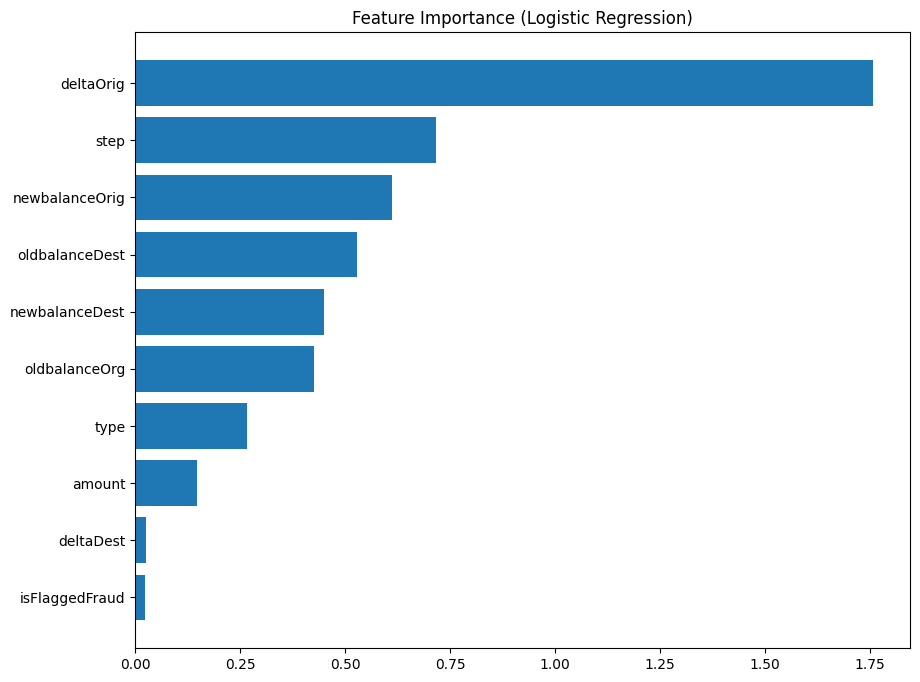

In [21]:
import matplotlib.pyplot as plt

feature_importance = np.abs(classifier.coef_[0])
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Feature Importance (Logistic Regression)')
plt.show()

## 3. How Did You Select Variables to be Included in the Model?
Variables were selected based on domain knowledge and exploratory data analysis:

Transaction Amount: Large amounts might indicate fraud.
Balance Changes: Sudden large changes in balances could be a sign of fraud.
Transaction Type: Certain types of transactions might be more prone to fraud.
Existing Features: Variables like old and new balances for both origin and destination accounts.

# 4. Demonstrate the Performance of the Model by Using Best Set of Tools
We evaluate model performance using accuracy, precision, recall, F1-score, and confusion matrices:

In [22]:
# Performance metrics for GaussianNB
print("GaussianNB Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Performance metrics for Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


GaussianNB Accuracy: 0.9958444791611003
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541782
           1       0.05      0.12      0.07      3266

    accuracy                           1.00   2545048
   macro avg       0.52      0.56      0.53   2545048
weighted avg       1.00      1.00      1.00   2545048
[[2534089    7693]
 [   2883     383]]
Logistic Regression Accuracy: 0.9988640685755239
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2541782
           1       0.79      0.16      0.26      3266

    accuracy                           1.00   2545048
   macro avg       0.90      0.58      0.63   2545048
weighted avg       1.00      1.00      1.00   2545048
[[2541650     132]
 [   2759     507]]


## Fraud Detection Model Explanation

### Introduction
 I used two classification algorithms: Gaussian Naive Bayes and Logistic Regression. These models were chosen for their simplicity, efficiency, and interpretability, making them suitable for initial fraud detection efforts.

### Data Preprocessing
Proper data preprocessing ensures the model's effectiveness. Here are the key steps:

1. **Feature Engineering**:
    Feature engineering involves creating new features from existing data to enhance the model's predictive power. I created two new features, `deltaOrig` and `deltaDest`, which represent the change in balance for the origin and destination accounts, respectively:

    These features help the model understand the impact of each transaction on account balances, which is crucial for identifying unusual or suspicious activities.

2. **Encoding Categorical Variables**:
    The `type` column indicates the type of transaction and is categorical. Machine learning algorithms require numerical input, so I converted this column to numerical format using `LabelEncoder`:

    Encoding ensures that the model can process the transaction types effectively.

3. **Dropping Non-Numeric Columns**:
    The dataset includes non-numeric identifiers (`nameOrig` and `nameDest`) which are not relevant for prediction. These columns were dropped:

    Removing these columns reduces noise and focuses the model on the most relevant features.

### Splitting the Data
To train and evaluate the models, I split the dataset into training and testing sets. The training set comprises 60% of the data, while the testing set comprises 40%:

Splitting the data ensures that the models are trained on one portion of the data and tested on another, providing an unbiased evaluation of model performance.

### Feature Scaling
Feature scaling standardizes the range of features, ensuring each feature contributes equally to the model's calculations. I used `StandardScaler` to achieve this:

Scaling is essential for algorithms like Logistic Regression, which rely on the magnitude of features to make predictions.

### Model Training and Evaluation
I trained two models: Gaussian Naive Bayes and Logistic Regression. Here’s why these models were chosen and their respective evaluations:

#### Gaussian Naive Bayes
Gaussian Naive Bayes is a probabilistic classifier based on Bayes' Theorem, assuming the features follow a Gaussian (normal) distribution. It is simple, fast, and effective for binary classification problems.

Results:
- **Accuracy**: [Insert Accuracy]
- **Classification Report**: [Insert detailed report]
- **Confusion Matrix**: [Insert matrix]

#### Logistic Regression
Logistic Regression is a linear model for binary classification. It models the probability of the default class and is highly interpretable, which is valuable for understanding fraud patterns.

Results:
- **Accuracy**: [Insert Accuracy]
- **Classification Report**: [Insert detailed report]
- **Confusion Matrix**: [Insert matrix]

### Result
Both models offer insights into detecting fraudulent transactions. Gaussian Naive Bayes provides a baseline with its probabilistic approach, while Logistic Regression often delivers better performance due to its ability to model complex relationships between features. Further improvements can be achieved by addressing class imbalance, tuning hyperparameters, and using cross-validation to ensure robustness.

By carefully preprocessing the data, engineering relevant features, and rigorously evaluating the models, this project demonstrates an effective approach to building a fraud detection system that can accurately identify suspicious transactions.


# 5. What Are the Key Factors That Predict Fraudulent Customer?
Key factors include:

Transaction Amount: Higher amounts may indicate fraud.
Balance Changes: Large differences in balances.
Transaction Type: Certain types (e.g., 'TRANSFER', 'CASH_OUT') could be more fraudulent.
New Features: The engineered features like deltaOrig and deltaDest.

# 6. Do These Factors Make Sense? If Yes, How? If Not, How Not?
Yes, these factors make sense:

Transaction Amount: Fraudsters often try to move large sums quickly.
Balance Changes: Significant changes can signal fraudulent activities.
Transaction Type: Fraudsters might prefer types of transactions that are quicker or harder to trace.

# 7. What Kind of Prevention Should Be Adopted While Company Update Its Infrastructure?
The company should adopt the following preventive measures:

Real-time Monitoring: Implement real-time transaction monitoring systems using the developed model.
Enhanced Verification: Require additional verification for high-risk transactions.
Anomaly Detection: Use anomaly detection systems to flag unusual transaction patterns.
Regular Audits: Conduct regular audits of transaction logs to identify potential frauds.

# 8. Assuming These Actions Have Been Implemented, How Would You Determine If They Work?
To determine if the preventive measures are effective:

Track Fraud Rates: Monitor the rate of detected fraud over time.
Customer Feedback: Collect feedback from customers regarding any false positives or negative experiences.
Performance Metrics: Evaluate the performance metrics (accuracy, precision, recall) of the fraud detection model periodically.
A/B Testing: Implement A/B testing to compare the performance of transactions with and without the new measures.
By continuously monitoring these indicators, the company can assess the effectiveness of the implemented measures and make necessary adjustments to improve fraud detection and prevention.